In [1]:
import numpy as np
import statsmodels.api as sm

from __future__ import division
from matplotlib import pyplot as plt
from random import seed
from random import randrange

%matplotlib inline

/Users/Xinhui/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def norm_base(x):
    return (2*x-np.min(x)-np.max(x))/(np.max(x)-np.min(x)), np.max(x), np.min(x)

def orth_base(x_n,degree):
    #Creating matrix given the required degree
    Z=np.zeros((len(x_n), degree + 1))
    a=np.zeros(degree+1)
    b=np.zeros(degree)
    Z[:,0]=1
    b[0]=0
    a[0]=0
    a[1]=np.mean(x_n)
    Z[:,1]=2*(x_n-a[1])
    for i in range(2,degree+1):
        a[i]=np.sum(np.multiply(x_n,np.multiply(Z[:,i-1],Z[:,i-1])))/np.sum(np.multiply(Z[:,i-1],Z[:,i-1]))
        b[i-1]=np.sum(np.multiply(Z[:,i-1],Z[:,i-1]))/np.sum(np.multiply(Z[:,i-2],Z[:,i-2]))
        Z[:,i]=2*(x_n-a[i]).dot(Z[:,i-1])-b[i-1]*Z[:,i-2]
    return Z.squeeze(),a,b

def fitting_OLS(reg_Y,reg_X):
    mod = sm.OLS(reg_Y, reg_X)
    res = mod.fit()
    return res.params

def regression_poly_wind(wind, X, Y, deg, delta, ploy_fit_func):
    if(len(X) != len(Y)):
        raise Exception('X and Y should have same length')
    if(len(X) < wind):
        raise Exception('Rolling window size should be larger than data size')
    
    beta = []
    pure_X = X
    pure_Y = Y
    
    for i in range((len(X)-wind)):
        reg_X = pure_X[i:i + wind]
        reg_Y = pure_Y[i:i + wind]
        x0 = reg_X[-1]
        #r0 = reg_X[-1]
        #sorted_X, sorted_Y = zip(*sorted(zip(reg_X, reg_Y)))
        beta.append(ploy_fit_func(reg_X, reg_Y, deg, x0, delta))
        #beta.append(ploy_fit_func(np.array(sorted_X), np.array(sorted_Y), deg, r0, delta))
    return beta

def normalize(x, max_x, min_x, a, b):
    
    x_norm = (2*x-max_x-min_x)/(max_x-min_x)
    x_transformed = np.array([1, 2*(x_norm -a[1]), 4*(x_norm-a[2])*(x_norm-a[1])-b[1]])
    
    return x_transformed
    

def duration_from_ortho_poly_fit_test(X, Y, deg, rate, delta):
    reg_X, a, b = orth_base(norm_base(X)[0], deg)
    max_x, min_x = norm_base(X)[1:]
    coef = np.array(fitting_OLS(Y, reg_X))
    
    rate_plus = rate + delta
    rate_minus = rate - delta
    
    price_plus = np.sum(coef * normalize(rate_plus, max_x, min_x, a, b))
    price_minus = np.sum(coef * normalize(rate_minus, max_x, min_x, a, b))
    
    return (price_plus - price_minus) / (delta * 2)


In [3]:
class TestFunctionGenerator():
    def __init__(self, coeffs_poly, coeff_data):
        '''coeffs: highest order to lowest order'''
        self.coeffs_poly = coeffs_poly
        self.degree = len(coeffs_poly) - 1
        self.coeff_data = coeff_data
        
    def get_poly(self):
        def tmp(x):
            return (((x.reshape(-1, 1))**np.arange(self.degree, -1, -1)).dot(self.coeffs_poly.reshape(-1, 1))).squeeze()
        return tmp
        
    def get_first_derivative(self):
        def tmp(x):
            weighted_coeffs = self.coeffs_poly[:-1] * np.arange(self.degree, 0, -1)
            return (((x.reshape(-1, 1))**np.arange(self.degree - 1, -1, -1)).dot(weighted_coeffs.reshape(-1, 1))).squeeze()
        return tmp
    
    def generate_random_walk(self):
        x0, mu, sig, dt = self.coeff_data[:-1]
        N = int(self.coeff_data[-1])
        data=[x0]
        path = np.random.normal(0, 1, N)
        for i in range(N):
            x = x0 + dt*mu + sig*path[i]
            data.append(x)
        return np.array(data)



def simulate_poly_fit(poly, poly_1st_derivative, degree_of_data, degree_of_fit, x, delta, mu_y, sig_y, window):
    #x = np.arange(-20, 20, 0.01)
    y = poly(x)
    yn = y + np.random.normal(mu_y, sig_y, len(x))  # generate data with noise

    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.plot(range(len(x)), x)
    ax.set_title('Plot 1 : Random Walk of Interest Rates')
    
    # test duration (first derivative) generated from orthogonal regression
    d = poly_1st_derivative(x)
    dt = regression_poly_wind(window, x, yn, degree_of_fit, delta, duration_from_ortho_poly_fit_test)
    
    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot(111)
    ax.plot(range(len(x)), d, c = 'red', alpha = 1, label = 'Theoretical Duration')
    ax.scatter(range(len(x)-window), dt, s = 0.1, c = 'green', alpha = 1,label = 'Fitted Duration')
    #ax.set_ylim([-3,3])
    ax.set_title('Plot 2: Theoretical Duration vs. Fitted Duration of Time Series')
    ax.legend()
    print('Mean (Empirical) :', np.mean(dt[:int(len(x)/2)-1]))
    print('Mean (Theoritical) :', np.mean(d))

## Window of Low Volatility and High Volatility

Mean (Empirical) : 0.15918212862
Mean (Theoritical) : 0.125003884556


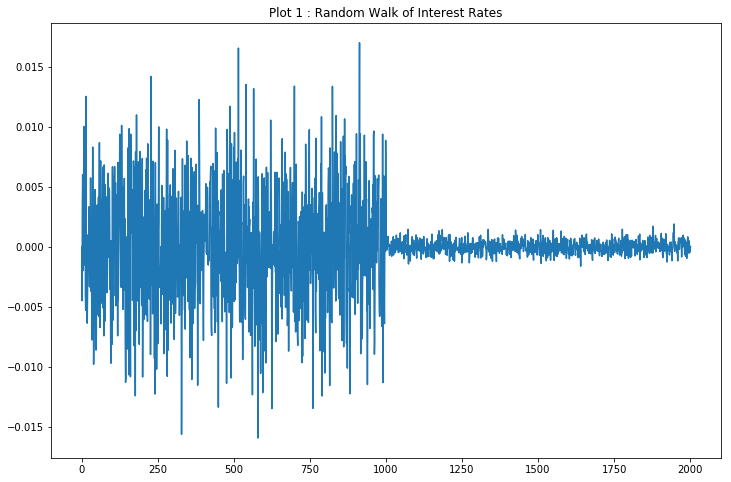

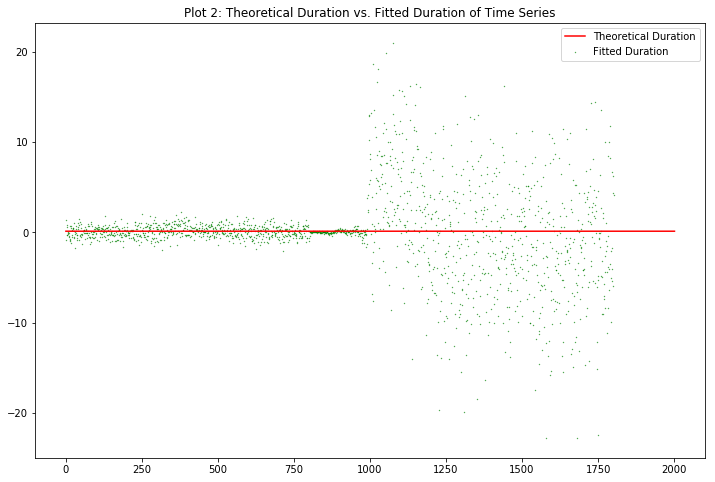

In [4]:
coeffs_poly = np.array([-0.0000154478, 0.000158474, 0.001282, -0.03658, 0.125, -0.3221])
coeffs_data = np.array([0, 0, 0.005, 0.01, 1000])
coeffs_data_low_vol = np.array([0, 0, 0.0005, 0.01, 1000])

fg1 = TestFunctionGenerator(coeffs_poly, coeffs_data)
fg2 = TestFunctionGenerator(coeffs_poly, coeffs_data_low_vol)
r_random_walk = np.concatenate((fg1.generate_random_walk(), fg2.generate_random_walk()), axis=0)

delta, mu_y, sig_y, window = 0.01, 0, 0.01, 200
simulate_poly_fit(fg1.get_poly(), fg1.get_first_derivative(), len(coeffs_poly) - 1, 2, r_random_walk, 
                  delta, mu_y, sig_y, window)

## Adding noise in price

Mean (Empirical) : 4.76981846479
Mean (Theoritical) : 0.124999681458


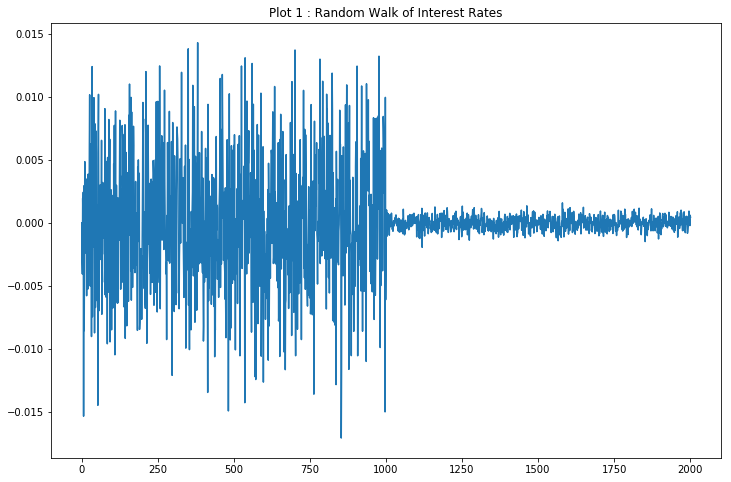

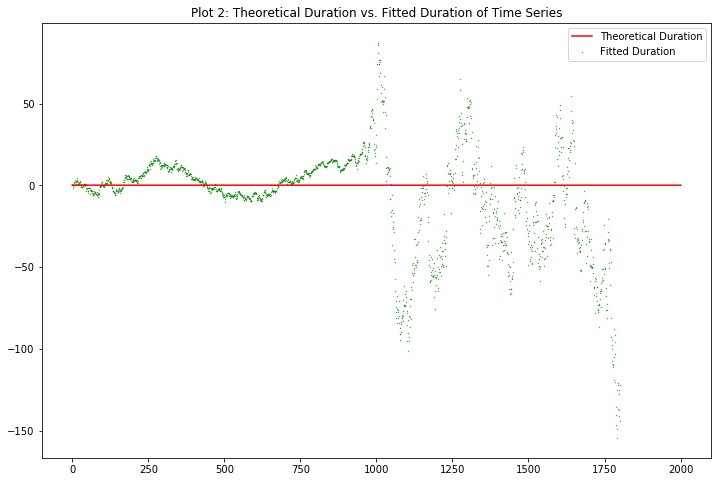

In [6]:
coeffs_poly = np.array([-0.03658, 0.125, -0.3221])
coeffs_data = np.array([0, 0, 0.005, 0.01, 1000])
coeffs_data_low_vol = np.array([0, 0, 0.0005, 0.01, 1000])

fg1 = TestFunctionGenerator(coeffs_poly, coeffs_data)
fg2 = TestFunctionGenerator(coeffs_poly, coeffs_data_low_vol)
r_random_walk = np.concatenate((fg1.generate_random_walk(), fg2.generate_random_walk()), axis=0)

delta, mu_y, sig_y, window = 0.0001, 0, 0.5, 200
simulate_poly_fit(fg1.get_poly(), fg1.get_first_derivative(), len(coeffs_poly) - 1, 2, r_random_walk, 
                  delta, mu_y, sig_y, window)